# Visualizing and Animating positions

In [1]:
## Load in some dependencies
library(dplyr); library(data.table); library(ggplot2); library(ggforce)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [2]:
nhwl_df <- read.csv("../input/nhwldata/Rotman MMA Summer Datathon NWHL.csv")
head(nhwl_df)

game_date  Home.Team           Away.Team    Period Clock Home.Team.Skaters
1 2021-01-23 Minnesota Whitecaps Boston Pride 1      20:00 5                
2 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:58 5                
3 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:57 5                
4 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:55 5                
5 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:53 5                
6 2021-01-23 Minnesota Whitecaps Boston Pride 1      19:52 5                
  Away.Team.Skaters Home.Team.Goals Away.Team.Goals Team         ⋯
1 5                 0               0               Boston Pride ⋯
2 5                 0               0               Boston Pride ⋯
3 5                 0               0               Boston Pride ⋯
4 5                 0               0               Boston Pride ⋯
5 5                 0               0               Boston Pride ⋯
6 5                 0               0               Boston Pride ⋯
  Event         X.Coordinate Y.Coordinate Detail.1 Detail.2 Detail.3 Detail.4
1 Faceoff Win   100          43           Backhand                           
2 Puck Recovery 107          40                                              
3 Zone Entry    125          28           Carried                            
4 Shot          131          28           Snapshot On Net   t        f       
5 Faceoff Win   169          21           Backhand                           
6 Puck Recovery 159          26                                              
  Player.2           X.Coordinate.2 Y.Coordinate.2
1 Stephanie Anderson NA             NA            
2                    NA             NA            
3 Maddie Rowe        NA             NA            
4                    NA             NA            
5 Stephanie Anderson NA             NA            
6                    NA             NA

In [3]:
nhwl_plays_df <- nhwl_df %>%
  filter(Event %in% c("Play", "Incomplete Play"), Detail.1 == "Direct", X.Coordinate >= 125, X.Coordinate.2 >= 125) %>%
  mutate(start_x = Y.Coordinate,
         start_y = X.Coordinate,
         end_x = Y.Coordinate.2,
         end_y = X.Coordinate.2,
         
         delta_x = end_x - start_x,
         delta_y = end_y - start_y,
         
         is_complete = ifelse(Event == "Play", 1, 0))

head(nhwl_plays_df,10)

game_date  Home.Team           Away.Team    Period Clock Home.Team.Skaters
1  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:43 5                
2  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:08 5                
3  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:51 5                
4  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:36 5                
5  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:29 5                
6  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:50 5                
7  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:40 5                
8  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:38 5                
9  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:32 5                
10 2021-01-23 Minnesota Whitecaps Boston Pride 1      16:30 5                
   Away.Team.Skaters Home.Team.Goals Away.Team.Goals Team                ⋯
1  5                 0               0               Minnesota Whitecaps ⋯
2  5                 0               0               Minnesota Whitecaps ⋯
3  5                 0               0               Boston Pride        ⋯
4  5                 0               0               Boston Pride        ⋯
5  5                 0               0               Boston Pride        ⋯
6  5                 0               0               Minnesota Whitecaps ⋯
7  5                 0               0               Boston Pride        ⋯
8  5                 0               0               Boston Pride        ⋯
9  5                 0               0               Boston Pride        ⋯
10 5                 0               0               Boston Pride        ⋯
   Player.2         X.Coordinate.2 Y.Coordinate.2 start_x start_y end_x end_y
1  Haley Mack       196            33             20      193     33    196  
2  Nina Rodgers     161            14             10      168     14    161  
3  McKenna Brand    175            47             65      195     47    175  
4  McKenna Brand    168            74             52      135     74    168  
5  Lauren Kelly     165            22             82      174     22    165  
6  Haylea Schmid    180            48             53      199     48    180  
7  Samantha Davis   180            42             64      175     42    180  
8  Taylor Turnquist 143            81             63      174     81    143  
9  Samantha Davis   198            46             61      198     46    198  
10 Lauren Kelly     163            10             19      193     10    163  
   delta_x delta_y is_complete
1   13       3     1          
2    4      -7     1          
3  -18     -20     0          
4   22      33     1          
5  -60      -9     0          
6   -5     -19     1          
7  -22       5     0          
8   18     -31     1          
9  -15       0     1          
10  -9     -30     1

In [4]:
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$Player == 'Taylor Woods', ]
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$Period == 2, ]
# nhwl_plays_df <- nhwl_plays_df[nhwl_plays_df$game_date == '2021-01-31', ]
# nhwl_plays_df

## Clustering

In [5]:
cluster_fit <- kmeans(nhwl_plays_df %>% select(start_x: delta_y), centers = 50)
nhwl_plays_df$cluster <- cluster_fit$cluster

In [6]:
cluster_summary <- nhwl_plays_df %>%
  group_by(cluster) %>%
  summarise(total_passes = n(),
            comp_rate = mean(is_complete))

risky_passes <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:3]

safe_passes <- (cluster_summary %>%
                   arrange(desc(comp_rate)) %>%
                   .$cluster)[1:3]

## Plotting static clusters

In [7]:
# Plot clusters
risky_dat <- bind_rows(nhwl_plays_df %>%
                         filter(cluster == risky_passes[1]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[2]) %>%
                         sample_n(20, replace = FALSE),
                       nhwl_plays_df %>%
                         filter(cluster == risky_passes[3]) %>%
                         sample_n(20, replace = FALSE))


risky_passes_plot <- ggplot(data = risky_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Risky Passes", size = 5.5, fill = "mistyrose")


safe_dat <- bind_rows(nhwl_plays_df %>%
                        filter(cluster == safe_passes[1]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[2]) %>%
                        sample_n(20, replace = FALSE),
                      nhwl_plays_df %>%
                        filter(cluster == safe_passes[3]) %>%
                        sample_n(20, replace = FALSE))


safe_passes_plot <- ggplot(data = safe_dat, aes(end_x, end_y, col = factor(cluster))) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Safe Passes", size = 5.5, fill = "azure")

Risky passes: 

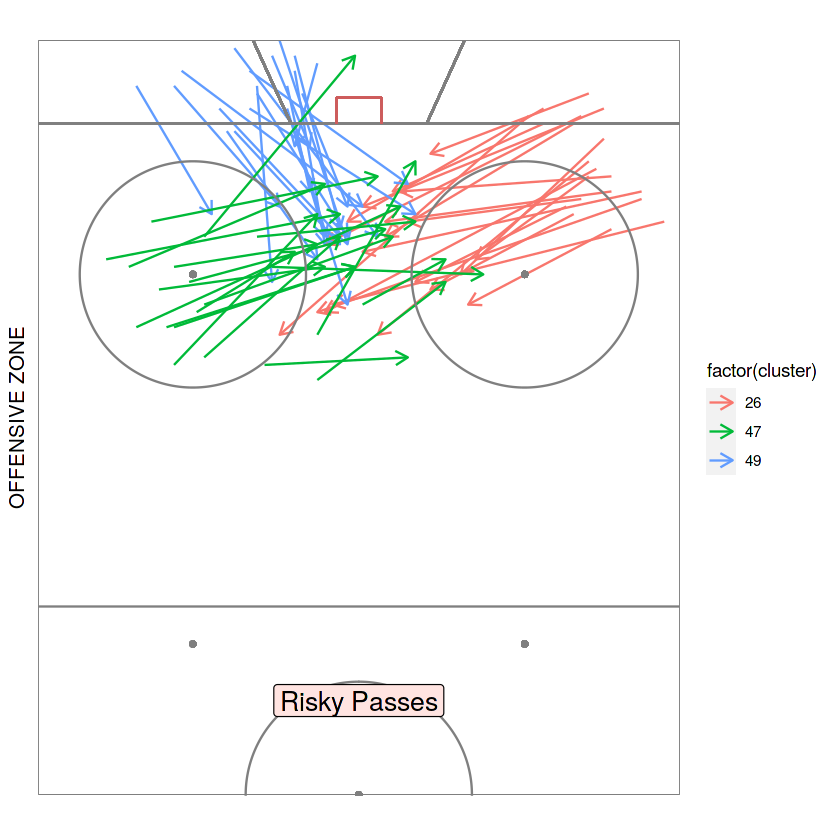

In [8]:
cat("Risky passes: ")
print(risky_passes_plot)

Safe passes: 

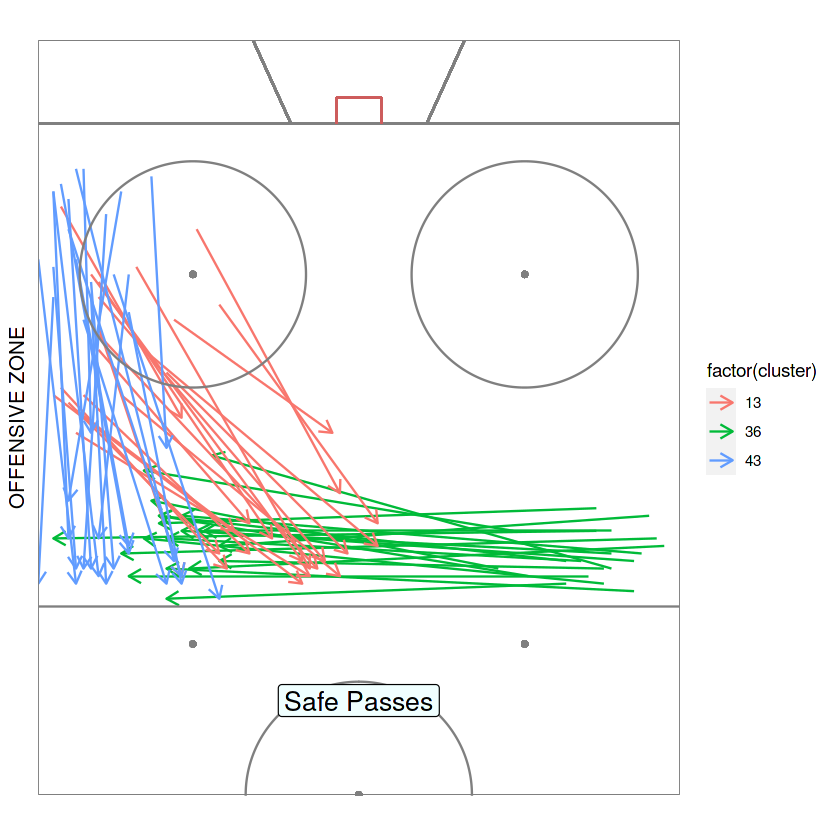

In [9]:
cat("Safe passes: ")
print(safe_passes_plot)

As we can see risky passes are close to the goal while the safe passes are away from the goal

In [10]:
library(gganimate)

anim <- risky_passes_plot + 
                      transition_states(Clock)

anim

## Visualizing the Passes of Taylor woods

In [11]:
passes_players_df <- nhwl_plays_df[nhwl_plays_df$Player == 'Taylor Woods',]
head(passes_players_df)

game_date  Home.Team             Away.Team           Period Clock
394 2021-01-23 Metropolitan Riveters Toronto Six         1      10:44
422 2021-01-23 Metropolitan Riveters Toronto Six         1      4:15 
424 2021-01-23 Metropolitan Riveters Toronto Six         1      4:12 
489 2021-01-23 Metropolitan Riveters Toronto Six         2      2:29 
933 2021-01-24 Toronto Six           Minnesota Whitecaps 1      12:12
951 2021-01-24 Toronto Six           Minnesota Whitecaps 1      8:34 
    Home.Team.Skaters Away.Team.Skaters Home.Team.Goals Away.Team.Goals
394 4                 5                 1               0              
422 4                 5                 1               0              
424 4                 5                 1               0              
489 5                 5                 2               0              
933 5                 4                 0               0              
951 5                 4                 2               0              
    Team        ⋯ X.Coordinate.2 Y.Coordinate.2 start_x start_y end_x end_y
394 Toronto Six ⋯ 162            10             27      131     10    162  
422 Toronto Six ⋯ 153            16             58      134     16    153  
424 Toronto Six ⋯ 149            63             40      129     63    149  
489 Toronto Six ⋯ 129            18             60      159     18    129  
933 Toronto Six ⋯ 135            14             47      135     14    135  
951 Toronto Six ⋯ 126            65             33      130     65    126  
    delta_x delta_y is_complete cluster
394 -17      31     1            1     
422 -42      19     1           29     
424  23      20     1           35     
489 -42     -30     1           41     
933 -33       0     1           14     
951  32      -4     1            4

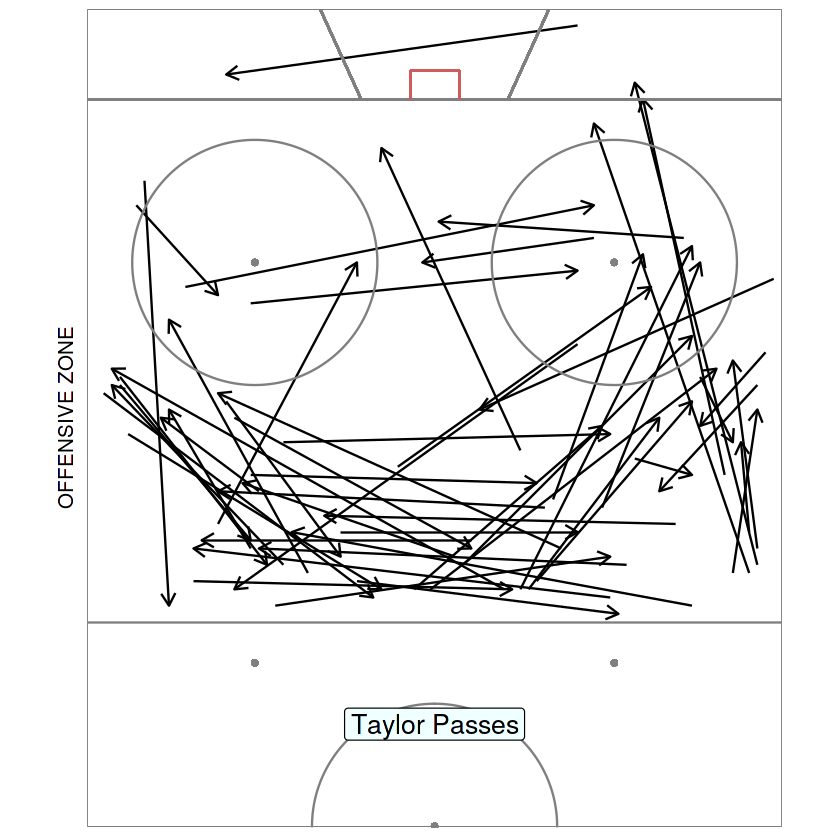

In [12]:
taylor_passes_plot <- ggplot(data = passes_players_df, aes(end_x, end_y)) + 
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.3, "cm"))) +
  geom_circle(data = data.frame(x0 = 42.5, y0 = 100, r = 15), aes(x0 = x0, y0 = y0, r = r), 
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 20.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_circle(data = data.frame(x0 = 64.5, y0 = 169, r = 15), aes(x0 = x0, y0 = y0, r = r),
              lwd = 0.5, col = "gray50", inherit.aes = FALSE) +
  geom_point(inherit.aes = FALSE, aes(x = 42.5, y = 100),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 169),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 20.5, y = 120),
             col = "gray50", size = 1) +
  geom_point(inherit.aes = FALSE, aes(x = 64.5, y = 120),
             col = "gray50", size = 1) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 0, y = 189, xend = 85, yend = 189)) +
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 45.5, yend = 192.5)) + 
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 39.5, y = 192.5, xend = 39.5, yend = 189)) +  
  geom_segment(col = "indianred", inherit.aes = FALSE, lwd = 0.5, aes(x = 45.5, y = 192.5, xend = 45.5, yend = 189)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 33.5, y = 189, xend = 28.5, yend = 200)) +
  geom_segment(col = "gray50", inherit.aes = FALSE, lwd = 0.5, aes(x = 51.5, y = 189, xend = 56.5, yend = 200)) +
  geom_hline(col = "gray50", yintercept = 125, lwd = 0.5) +
  scale_x_continuous(expand = c(0, 0)) + scale_y_continuous(expand = c(0,0)) +
  ylab("OFFENSIVE ZONE") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y = element_text(size=12),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "gray50", fill=NA, size=0.2)) +
  coord_fixed(xlim = c(0,85), ylim = c(100,200)) +
  annotate("label", x = 42.5, y = 112.5, label = "Taylor Passes", size = 5.5, fill = "azure")

taylor_passes_plot

In [ ]:
library(gganimate)

anim <- taylor_passes_plot + transition_states(end_x)

anim

In [13]:
cluster_taylor_passes <- kmeans(passes_players_df %>% select(start_x: delta_y), centers = 5)
passes_players_df$cluster <- cluster_taylor_passes$cluster
cluster_taylor_passes

K-means clustering with 5 clusters of sizes 9, 6, 10, 14, 16

Cluster means:
   start_x  start_y    end_x    end_y   delta_x    delta_y
1 49.77778 133.4444 71.55556 160.3333  21.77778  26.888889
2 26.83333 136.8333 16.83333 161.5000 -10.00000  24.666667
3 79.00000 141.9000 73.60000 160.1000  -5.40000  18.200000
4 62.28571 147.2857 23.07143 148.8571 -39.21429   1.571429
5 14.93750 150.6250 43.68750 140.0625  28.75000 -10.562500

Clustering vector:
 394  422  424  489  933  951  955 1027 1057 1058 1063 1071 1104 1139 1161 1192 
   2    4    1    4    4    5    2    5    3    3    3    3    4    5    4    4 
1289 1291 1294 1345 1808 1858 1859 1863 1868 1887 1921 1938 1940 1959 2231 2238 
   5    5    5    5    2    5    4    3    4    5    5    4    1    4    2    4 
2241 2255 2256 2305 2308 2313 2318 2319 2344 2422 2654 2656 2662 2681 2724 2726 
   5    5    3    5    2    3    5    3    3    5    4    1    1    1    4    1 
2729 2734 2738 2740 2742 2751 2771 
   1    2    4    1    1   

In [14]:
cluster_summary <- passes_players_df %>%
                      group_by(cluster) %>%
                      summarise(total_passes = n(),
                      comp_rate = mean(is_complete))


risky_passes <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:5]

safe_passes <- (cluster_summary %>%
                   arrange(desc(comp_rate)) %>%
                   .$cluster)[1:3]

risky_passes

[1] 2 3 1 4 5

In [16]:
image <- jpeg::readJPEG("../input/ice-hockey-half-rink/ice_hockey_half_rink.jpg")

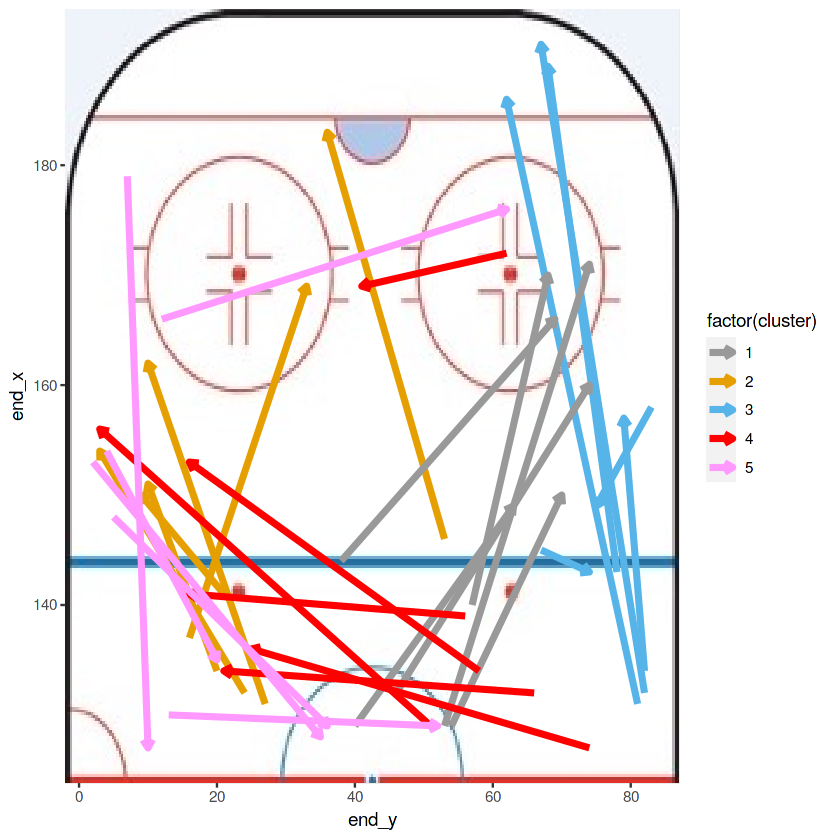

In [17]:
library(grid)
library(ggpubr)
#library(gggenes)

risky_dat <- bind_rows(passes_players_df %>%
                         filter(cluster == risky_passes[1]) %>%
                         sample_n(6, replace = FALSE),
                       passes_players_df %>%
                         filter(cluster == risky_passes[2]) %>%
                         sample_n(6, replace = FALSE),
                       passes_players_df %>%
                         filter(cluster == risky_passes[3]) %>%
                         sample_n(6, replace = FALSE),
                      passes_players_df %>%
                         filter(cluster == risky_passes[4]) %>%
                         sample_n(6, replace = FALSE),
                      passes_players_df %>%
                         filter(cluster == risky_passes[5]) %>%
                         sample_n(6, replace = FALSE))


risky_passes_plot <- ggplot(data = risky_dat, aes(end_y, end_x, col = factor(cluster))) + 
  background_image(image) +
  geom_segment(aes(x = start_x, y = start_y, xend = end_x, yend = end_y),
               arrow = arrow(length = unit(0.2, "cm")), size=1.5) +
  scale_fill_continuous(guide = FALSE) +
  scale_color_manual(values=c('#999999','#E69F00', '#56B4E9', '#ff0000', '#ff99ff'))

risky_passes_plot

In [ ]:
save.image(file = "taylor_plays.Rdata", oldstyle = FALSE)

In [91]:
library(gganimate)

anim <- risky_passes_plot + transition_states(end_x)

anim

<img src="data:image/gif;base64,R0lGODlh4AHgAfcAAAoJCw0OERQTFBwbHRcWGRQOESEdHicYFjkUEBwdIiUdIhUkLiMhIioq
KyclKD49PTU0NTAtMCAiHkI7O1o1KFshGDw8Qi4/RUE8QC5QZEdHSFBOT1dWWFBOUV1dZGZm
aHNxcnx8fHR2eHJvcWJfYLs6NLU7NbE4M4c0L/8AAP4LC/8XF+YRFt4zKtk3Kcw4Nf8oKP42
NuIzKt0uH7NBPMZCO+JSPJdLTLZJRq1QT41qapRsa5VtdJl3d49xcKR8e7NucKtgX9tSSM5Q
TOJPRuJOSOlPRf5ISOFRSP5XV81tav5nZ/54eOZwbspiW6EvROafAOeiB+ioGOuxL9SfG5yB
fqSCfaWhZ+y6SfDJbu7BWqSPNyVtnSttmSZwny10njZtjyVxpCVvoRtwpXJ9hFB0i5l6hYR8
gqZ9gq5+lMJ8hnmMl3GJkl2cv12Wt22WsV6Cll2bw2+rzm2lwHKqzneoxG6s01e06WKq1X/E
7ISEhIiHh4yLjIaHiZqFhpOTlJubnJiXmoiTmKOEg6uMi6iHh7KNjLaGh6qRjKqMlreNk6uU
l7STlLmYmbWSjbmgnI2apKuWo7iZo7KPp5WpsqOjpKuqq6mlqLmmqLGvsLmqt7Oxsry8vba0
uK2xs5KnlcWZmtaSkv2WlvGRj8uinMWdpceoqNSpqdOyrtuzqsertMu2ttSysdi5uc+vr/2n
puS5ufy5uOeuquminvPVkNnBvv/CvfjBue3Qs/fjtbC8yKK30tm9w8u6z/+Z/+2357jF2bDE
0a3K5avI6rPE5bPF7LjI6LXP7ZXN7MfHyNvCwtjHyMnH2tjY2c3N2evMy+bGxv/Dw/jLyuvS
zO3d2+jW1PTd3Pzc3PjW1fLO0Pzi3vbl2vbq0M/U4/re4e3Z7Nrr9N///93y+9Xi6uvr7OXk
5f7k4/7q5f/m6f/s7PTm5v/y7f347Ozu8+bt9v/t8vPr9e3x9u/0+uP//+39/+X1/PLz8//0
8/b79v769fL0+v72+vT+/v///+T26HmDWSH5BAQKAAAAIf8LTkVUU0NBUEUyLjADAQAAACwA
AAAA4AHgAQAI/gD7CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihxJsqTJ
kyhTqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtChGffb0KV2Kb6nSpEuhIlUab2k8
eVWdar2qVZ69r1CbRrW372lZe+2a9tOHr23bcuWaOePEyVIgPXjz6s27Z6/evnsCCx7MZ7Dg
woERG168WHFhxYwZO44cGXJiypgnX75cGG9fv33/eFqVzFmzcmzZ4lu7D99XpK6nvraqTx7V
rE/t4Y4qdqrvpL2fOpWalLjS1UaBylu+vOry2ravNofOvHrz69epMufqHPtS2/ye/q9d2o6c
vrX9kOOL16xZskt8+HyYwMCA/QED6g+4b0DCffz7GcCABAwUaOCBCCao4IIMNujggxBGKCGE
BijgnwL55ccABCPsccklujSzzz4DkbgPWPrA49RVXF1Xz3IvWscVdC1mVZV03UGnj3RYUWed
decl95N0PmLFHHU7AilPjPTguJ1SRsZom4+12Yibimi1o9RASpXjTCWVhDACBxw8AEEDETQg
gQACEMDmm28WECecbxLgJpt31knnnnvmiSefgP4Jp5+BDkonoYUKqmeijM5Zp512ovnABBhw
QMIHZ1xSWjn2cInUiVoqFd6P25VKajw3QnXqkUfy+Byr/j0KOSSpr9JKq6v01Gpbc7kqCeWv
UMJjWzuhDmQbOV9WQsYHZJoZQZpuRiunnAJQWy2c095pZ6OMIsrtt92CK+64dFJrbbR2Pmum
Bhx8gGklziTDqUBlOaViVf3Aaqu+PXJXHZX7miqjrD7VWuS+tR0sT5OkKrxrdcLuqCJ57QiU
Yjm9kNFBBxEMsC2dBUagwcgbkGnyyShbSmYHG7SsQcswxyzzzDTXbPPNOOes884847xxByuv
PPIDESTAZgAEBBAAm/hFwMEZZHBSTj8kpqYPsdnV9qKruvraNXO9fr0cPVBWR0+nBPMkdsNK
Przkjzoi/GqK8hCrlIrwwFO1/j7l1KIxxx776WaBDWBAMgkpp4y4ySz37PjjkEcu+eQycwB0
ByNbAIHR1Q5QANIE4AdBB2ecIfV4TtmNVTz8QOlOwGtX16LbcO+Ldto6cU1rkb/SKqXvbWt1
d8UpIguIBx40oHSbEjTwwAMeiADIJ5wsAxc5JGJEYj70Uk1Q9t17X6L444MfvvnZp//9+uR7
b777Bam/vvzhnz9++/jHL1A7Xi7TSyAhEAEHLOAABxigTQIIQAM4AIhANAMq/AjVjspWNtjZ
imwW5N2PcLcTtsWOVQfb2r9olTfmwCNUeetHUnrxB8slAAAJTIAFPtCHPnTigbdDDgd3qJDs
4aMs/uh5nwpPs4k9WEoDDgCAEh3Qgfgk4zlla8eUApYkC9ZuhLa6HQ9r0rYuUqk7q7LicyKm
pU6lSBd8INML2STDD+zBhpxCmw7jxz2KzHGLOGlNegTSFvDhoz2bkM8HCKhEADCgA4LgwxPl
UZYI1m2KVOwVwOYmxrbh0SZEoqLuJkirsBmJVMJaDt4G4ow/AK0BAFBaAzzwhz8kgxx3NIg+
WhNLgwjxkrJSzx75aI9yJCMQ7kqiKjnQSmfww2Krg44kxTZJudWuSFrEJUxsdbCEBe9WsAul
PPpRMYE0IxAbU14qV9nKV0bTINz7YUFqKc2hrIadq3mfPe5RjmD8wV2o/lRlByDxh2YEaXVZ
8UoXxVhNKwapndOs5MO+o0Es7sqaUFxKP5IxgkF6rgAK+EAkIoEaqqlzluDz4zoRikfk3HKO
2SNHO5phCeQNYGkCiMAIkpGM83wHHjmiHewcpg9P8pSkMOGaw4DkFFD+CFX/0spakuEBzhUA
An/gQzMeIkR1ApWk7LSlCvn2hwdYwE4JSIAHknFMHbHog0M9KjVld1WXOHSgR1IRFNfaoykl
zCn86AUHFHA0qPZzIbesI1vaStj4yZOrXgWrWJOBTJ2mlV/6eqyOCrsStO5urm7bEapqE6p4
TMw2SYGHMz4wArBuTBN6CyllV/sRpVSiAw5A/uUA3MUM1jHFHVJklTucM6rLwvWoB2VtSfzl
WyDJlZPUQRXrNpskreyDHM1wl8cOuYFMkOWWgBWudhXyFUtsoIABSIC7nhgeUbXjdZmMhzu+
48xKxmO7JRnbWxGGpH8R6UZXyW2K4iWClwYAAhzoxInYh134Ghh/q0lnp/BBlw8orwALmGnC
qlJed7yuoAa94kMPLBIexY1tAFOYcquCFnKMZx/jCAEELBDeigbjHulJH9r2UUcO2xgh7MwH
RUeQgABEIARkmKpS2kHhu9amdR/UaXXwIbv33tgjdF3rZ2XEoqrgw24W+wYZIACBFn9gFecZ
Eb0K/OQyIyQfwRgB/o99TIYzUIMfJCIyQ6nSW0oqdMlm5ghkh9rQ6rRuyEoFkwVeCAAOJKMd
aDuoavNR4zw/WaS8tAdTARBWCFyCS8zVzuuK297tOFojuqNmn4l6FbI4pR+CJrSh4YG225H5
02Y+5kDggQ+mhjcBlm7d/iSYpFBj0R6QJJUkYY2RET6W01ghFgqFVY6m9tjSliBIcAmCnEYT
m7CvLpEuZ5kJNCWAABzwgD/FAmwpHhts1bEHBrHo5GtTxNdvrSDb8LUWFXmiExAQgAIYIALU
KKVqArG2ux2dVe+NoxwjUICdIKALu33HHfmCbCWRO3CK7DSz/NLRBC2mok7gWwAE6vd4/qid
7YobWI8IIRFcePxtCHSCHPeCUlqoKEYWTdvkDXGVws69HeWKqhxnCGsANODx4GaVHwXHOWV1
CPDyZY8TLwsv1KbGang4cqFKni

## Goal Clustering

In [31]:
nhwl_shots_df <- nhwl_df %>%
  filter(Event %in% c("Shot", "Goal"), X.Coordinate >= 125) %>%
  mutate(start_x = Y.Coordinate,
         start_y = X.Coordinate,
         is_complete = ifelse(Event == "Goal", 1, 0))

head(nhwl_shots_df,10)

game_date  Home.Team           Away.Team    Period Clock Home.Team.Skaters
1  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:55 5                
2  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:21 5                
3  2021-01-23 Minnesota Whitecaps Boston Pride 1      19:07 5                
4  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:34 5                
5  2021-01-23 Minnesota Whitecaps Boston Pride 1      18:26 5                
6  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:50 5                
7  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:18 5                
8  2021-01-23 Minnesota Whitecaps Boston Pride 1      16:15 5                
9  2021-01-23 Minnesota Whitecaps Boston Pride 1      15:56 5                
10 2021-01-23 Minnesota Whitecaps Boston Pride 1      15:49 5                
   Away.Team.Skaters Home.Team.Goals Away.Team.Goals Team                ⋯
1  5                 0               0               Boston Pride        ⋯
2  5                 0               0               Minnesota Whitecaps ⋯
3  5                 0               0               Minnesota Whitecaps ⋯
4  5                 0               0               Boston Pride        ⋯
5  5                 0               0               Boston Pride        ⋯
6  5                 0               0               Minnesota Whitecaps ⋯
7  5                 0               0               Boston Pride        ⋯
8  5                 0               0               Boston Pride        ⋯
9  5                 0               0               Boston Pride        ⋯
10 5                 0               0               Minnesota Whitecaps ⋯
   Detail.1    Detail.2 Detail.3 Detail.4 Player.2 X.Coordinate.2
1  Snapshot    On Net   t        f                 NA            
2  Snapshot    On Net   f        f                 NA            
3  Snapshot    Missed   f        f                 NA            
4  Snapshot    On Net   f        f                 NA            
5  Snapshot    On Net   f        f                 NA            
6  Snapshot    On Net   f        f                 NA            
7  Snapshot    On Net   f        f                 NA            
8  Wrap Around On Net   f        f                 NA            
9  Snapshot    On Net   f        f                 NA            
10 Snapshot    On Net   f        f                 NA            
   Y.Coordinate.2 start_x start_y is_complete
1  NA             28      131     0          
2  NA              2      162     0          
3  NA             18      167     0          
4  NA             68      175     0          
5  NA             20      196     0          
6  NA             43      181     0          
7  NA             10      163     0          
8  NA             49      188     0          
9  NA             19      149     0          
10 NA             67      167     0

In [33]:
dim(nhwl_shots_df)

[1] 1981   24

In [34]:
## Subsetting for player
taylor_shots_df <- nhwl_shots_df[nhwl_shots_df$Player == 'Taylor Woods', ]
head(taylor_shots_df)

game_date  Home.Team             Away.Team   Period Clock Home.Team.Skaters
281 2021-01-23 Metropolitan Riveters Toronto Six 1      10:51 4                
282 2021-01-23 Metropolitan Riveters Toronto Six 1      10:40 4                
306 2021-01-23 Metropolitan Riveters Toronto Six 1      4:05  4                
324 2021-01-23 Metropolitan Riveters Toronto Six 2      14:18 4                
359 2021-01-23 Metropolitan Riveters Toronto Six 3      13:44 5                
368 2021-01-23 Metropolitan Riveters Toronto Six 3      10:35 5                
    Away.Team.Skaters Home.Team.Goals Away.Team.Goals Team        ⋯ Detail.1 
281 5                 1               0               Toronto Six ⋯ Wristshot
282 5                 1               0               Toronto Six ⋯ Slapshot 
306 5                 1               0               Toronto Six ⋯ Wristshot
324 5                 2               0               Toronto Six ⋯ Wristshot
359 5                 2               0               Toronto Six ⋯ Snapshot 
368 5                 2               0               Toronto Six ⋯ Wristshot
    Detail.2 Detail.3 Detail.4 Player.2 X.Coordinate.2 Y.Coordinate.2 start_x
281 On Net   t        f                 NA             NA             34     
282 Missed   t        f                 NA             NA             42     
306 Missed   t        f                 NA             NA             21     
324 On Net   t        f                 NA             NA             54     
359 On Net   t        f                 NA             NA             81     
368 Blocked  t        f                 NA             NA             77     
    start_y is_complete
281 134     0          
282 130     0          
306 146     0          
324 139     0          
359 133     0          
368 135     0

In [35]:
dim(taylor_shots_df)

[1] 46 24

In [49]:
cluster_taylor_goals <- kmeans(taylor_shots_df %>% select(start_x: start_y), centers = 3)
taylor_shots_df$cluster <- cluster_taylor_goals$cluster
cluster_taylor_goals

K-means clustering with 3 clusters of sizes 12, 20, 14

Cluster means:
   start_x  start_y
1 59.50000 168.6667
2 69.85000 139.7500
3 29.64286 143.8571

Clustering vector:
 281  282  306  324  359  368  380  386  666  668  670  697  707  723  729  819 
   3    3    3    2    2    2    3    3    3    1    1    2    1    1    1    3 
 821  838  841  868  891 1204 1259 1275 1283 1290 1291 1479 1487 1501 1521 1524 
   2    1    1    3    1    2    2    1    2    2    2    2    3    2    3    2 
1531 1533 1539 1559 1606 1607 1744 1767 1768 1781 1806 1808 1815 1826 
   1    2    1    2    1    2    2    3    3    2    3    3    2    2 

Within cluster sum of squares by cluster:
[1] 2265.667 2918.300 3076.929
 (between_SS / total_SS =  71.1 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

In [52]:
cluster_summary <- taylor_shots_df %>%
                  group_by(cluster) %>%
                  summarise(total_passes = n(),
                  comp_rate = mean(is_complete))

all_shots <- (cluster_summary %>%
                   arrange(comp_rate) %>%
                   .$cluster)[1:3]


In [53]:
cluster_summary

cluster total_passes comp_rate 
1 1       12           0.25000000
2 2       20           0.00000000
3 3       14           0.07142857

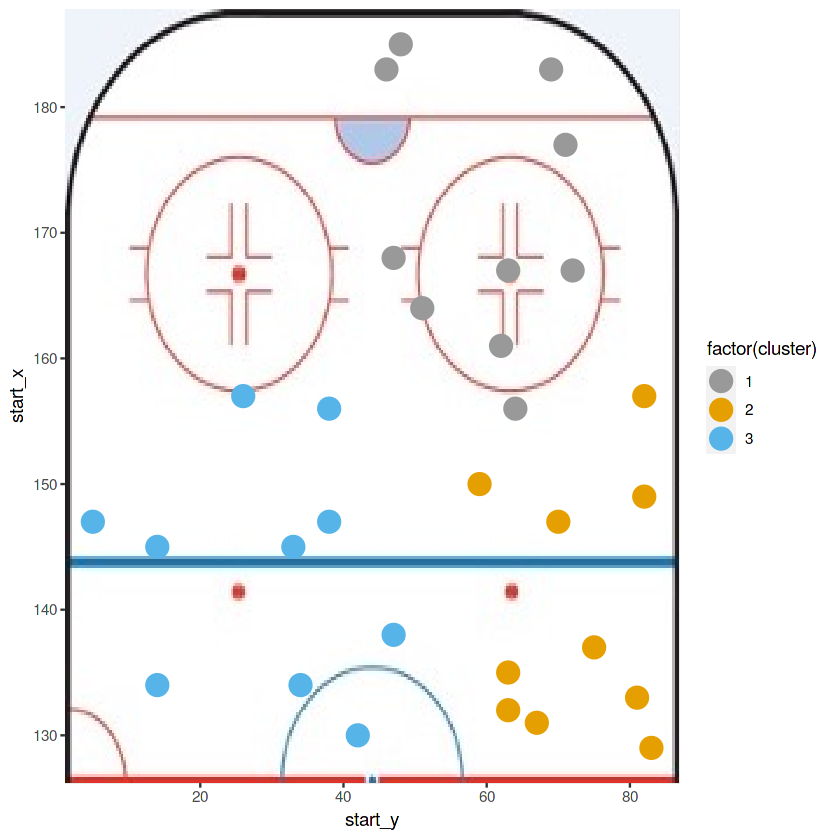

In [83]:
goals_data <- bind_rows(taylor_shots_df %>%
                         filter(cluster == all_shots[1]) %>%
                         sample_n(10, replace = FALSE),
                       taylor_shots_df %>%
                         filter(cluster == all_shots[2]) %>%
                         sample_n(10, replace = FALSE),
                       taylor_shots_df %>%
                         filter(cluster == all_shots[3]) %>%
                         sample_n(10, replace = FALSE))
#                       taylor_shots_df %>%
#                          filter(cluster == all_shots[4]) %>%
#                          sample_n(5, replace = FALSE),
#                       taylor_shots_df %>%
#                          filter(cluster == all_shots[5]) %>%
#                          sample_n(5, replace = FALSE))


shots_plot <- ggplot(data = goals_data, aes(start_y, start_x, col = factor(cluster))) + 
  background_image(image) +
  geom_point(aes(x = start_x, y = start_y, col=factor(cluster)), size=5, stroke=1) + 
  #ggforce::geom_mark_ellipse(aes(start_y, start_x, group = cluster, label = cluster), inherit.aes=FALSE) +
  #             arrow = arrow(length = unit(0.2, "cm")), size=1.5) +
  scale_fill_continuous(guide = FALSE) +
  scale_color_manual(values=c('#999999','#E69F00', '#56B4E9', '#ff0000', '#ff99ff'))

#shots_plot + ggforce::geom_mark_ellipse(aes(start_y, start_x, group = cluster, label = cluster), inherit.aes=TRUE)
shots_plot

Thus shots near the goal can have higher expected goal rate. Could be used for improvement of player.

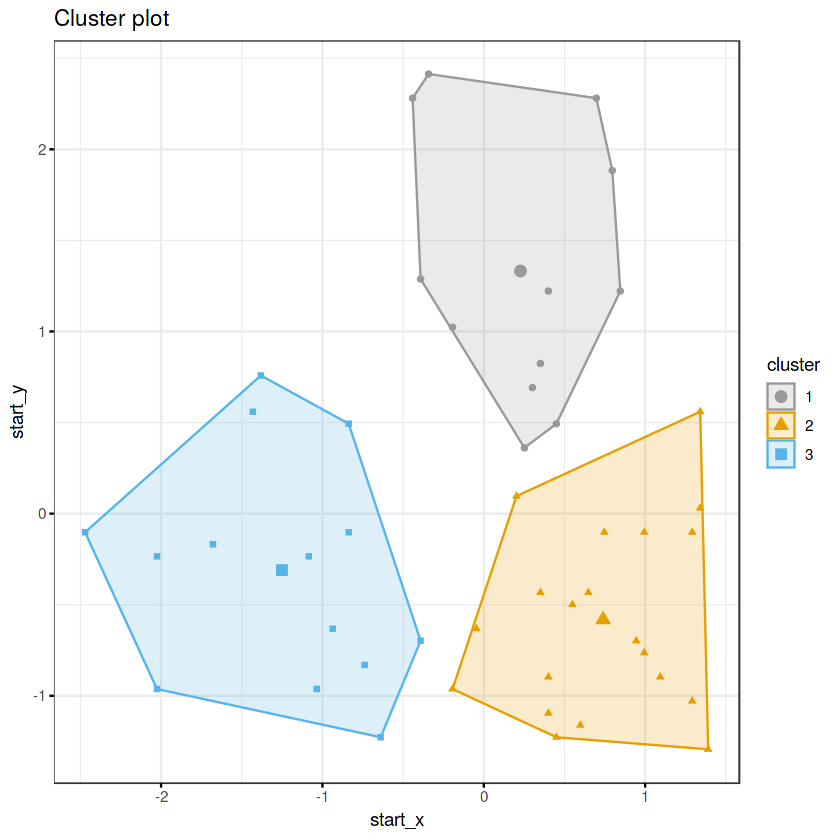

In [90]:
library(factoextra)
p <- fviz_cluster(cluster_taylor_goals, taylor_shots_df %>% select(start_x: start_y), 
             #aes(start_y, start_x, col = factor(cluster)),
             palette = c('#999999','#E69F00', '#56B4E9', '#ff0000', '#ff99ff'), 
             geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
             ) 

p

## Clustering using DBscan

In [71]:
library(fpc)
ds <- dbscan(taylor_shots_df %>% select(start_x: start_y), eps=0.01, MinPts=5)
ds

dbscan Pts=46 MinPts=5 eps=0.01

 0 
46 